In [1]:
!pip install vncorenlp
!pip install transformers==4.8.2
!pip install emoji
!pip install sentence_transformers

     |████████████████████████████████| 2.6 MB 7.9 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=f0c5ebc56a31a1b922c5919c70751e21d36556f2907081f561892f9fa10cf84d
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp
     |████████████████████████████████| 2.5 MB 9.6 MB/s 
     |████████████████████████████████| 3.3 MB 48.4 MB/s 
     |████████████████████████████████| 895 kB 53.7 MB/s 
     |████████████████████████████████| 168 kB 7.7 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=762335df122f7e095ac40e1530b4949435a7407f67b217bad5449df2479cec12
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji
     |████████████████████████████████| 78 kB 4.8 MB/s 
     |████████████████████████████████| 1.2 MB 17.9 MB/s 
  Created wheel for sent

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
!nvidia-smi

Sun Oct 10 06:30:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_path = "/content/drive/MyDrive/VLSP-Fake-News-Detection/public_train.csv"
test_path = "/content/drive/MyDrive/VLSP-Fake-News-Detection/final_private_test.csv"
val_path = "/content/drive/MyDrive/VLSP-Fake-News-Detection/val.csv"

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle, os, re, json
import matplotlib.pyplot as plt
import torch
import gc
import torch.nn as nn

from vncorenlp import VnCoreNLP
from nltk.tokenize import TweetTokenizer
from scipy.stats import zscore
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from collections import *
from datetime import datetime
from transformers import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from transformers import logging
from lightgbm import LGBMClassifier, LGBMModel
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from pandas import DataFrame
from pandas._libs.missing import NAType

In [6]:
data_train = pd.read_csv(train_path, encoding="utf-8")
data_test = pd.read_csv(test_path, encoding="utf-8")
data_val = pd.read_csv(val_path, encoding="utf-8")

In [7]:
#Time stamp feature
data_train['timestamp_post'] = pd.to_numeric(data_train['timestamp_post'], errors='coerce')
data_train['timestamp_post'] = data_train['timestamp_post'].astype('Int64')

data_test['timestamp_post'] = pd.to_numeric(data_test['timestamp_post'], errors='coerce')
data_test['timestamp_post'] = data_test['timestamp_post'].astype('Int64')

#Number of shares feature
data_train['num_share_post'] = pd.to_numeric(data_train['num_share_post'], errors='coerce')
data_train['num_share_post'] = data_train['num_share_post'].astype('Int64')
data_test['num_share_post'] = pd.to_numeric(data_test['num_share_post'], errors='coerce')
data_test['num_share_post'] = data_test['num_share_post'].astype('Int64')

#Number of likes feature
data_train['num_like_post'] = pd.to_numeric(data_train['num_like_post'], errors='coerce')
data_train['num_like_post'] = data_train['num_like_post'].astype('Int64')
data_test['num_like_post'] = pd.to_numeric(data_test['num_like_post'], errors='coerce')
data_test['num_like_post'] = data_test['num_like_post'].astype('Int64')

#Number of comments feature
data_train['num_comment_post'] = pd.to_numeric(data_train['num_comment_post'], errors='coerce')
data_train['num_comment_post'] = data_train['num_comment_post'].astype('Int64')
data_test['num_comment_post'] = pd.to_numeric(data_test['num_comment_post'], errors='coerce')
data_test['num_comment_post'] = data_test['num_comment_post'].astype('Int64')

data_train['post_message'] = data_train['post_message'].fillna('empty')

In [8]:
timestamp_lst = data_train['timestamp_post']
likes_lst = data_train['num_like_post']
comment_lst = data_train['num_comment_post']
share_lst = data_train['num_share_post']

test_timestamp_lst = data_test['timestamp_post']
test_likes_lst = data_test['num_like_post']
test_comment_lst = data_test['num_comment_post']
test_share_lst = data_test['num_share_post']

In [9]:
def null_index_list(df, feature):
  return df[feature][df[feature].isnull()].index.tolist()

In [10]:
nan_timestamp_idxs = null_index_list(data_train, "timestamp_post")
nan_like_idxs = null_index_list(data_train, "num_like_post")
nan_share_idxs = null_index_list(data_train, "num_share_post")
nan_comment_idxs = null_index_list(data_train, "num_comment_post")

In [11]:
test_nan_timestamp_idxs = null_index_list(data_test, "timestamp_post")
test_nan_like_idxs = null_index_list(data_test, "num_like_post")
test_nan_share_idxs = null_index_list(data_test, "num_share_post")
test_nan_comment_idxs = null_index_list(data_test, "num_comment_post")

In [12]:
def normalizePost(post, tweet_tokenizer, vncorenlp, use_segment=False, remove_punc_stopword=False, lowercase_opt=False, truncation_method="head_only", length=512):
    post = post.strip()
    URL_pattern = r"(?:http?s://|www.)[^\"]+"
    hashtag_pattern = r"#\s?\w+"

    post = re.sub(URL_pattern, "link", post)
    post = re.sub(hashtag_pattern, "hashtag", post)
    post = re.sub('\.+','.', post)
    if lowercase_opt:
      post = post.lower()
    tokens = tweet_tokenizer.tokenize(post.replace("’", "'").replace("…", "..."))
    
    post = " ".join(tokens)
    if use_segment:
        tokens = vncorenlp.tokenize(post.replace("’", "'").replace("…", "..."))
        tokens = [t for ts in tokens for t in ts]
    normPost = " ".join(tokens)

    if remove_punc_stopword:
      tokens = [t for t in normPost if not t in vnmese_stopwords]
    normPost = " ".join(tokens)

    normPost = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normPost)
    normPost = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normPost)
    normPost = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normPost)
    if use_segment:
        normPost = normPost.replace('< url >', '<url>')
        normPost = re.sub(r"# (\w+)", r'#\1', normPost)
    if truncation_method == "head_only":
      normPost = " ".join(normPost.split(" ")[:length])
    if truncation_method == "tail_only":
      normPost = " ".join(normPost.split(" ")[-length:])
    if truncation_method == "head_tail":
      normPost = " ".join(normPost.split(" ")[:int(length*0.25)]) + " " +  " ".join(normPost.split(" ")[-int(length*0.75):])
    return normPost

In [13]:
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/VLSP-Fake-News-Detection/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg")
tweet_tokenizer = TweetTokenizer()

In [14]:
sentences = data_train['post_message'].tolist()
sents = []
test_sents = []

for post in data_train.post_message:
  sents.append(normalizePost(post, tweet_tokenizer, rdrsegmenter, True, False, False, "head_only", 512))

for test_post in data_test.post_message:
  test_sents.append(normalizePost(test_post, tweet_tokenizer, rdrsegmenter, True, False, False, "head_only", 512))

In [15]:
from sentence_transformers import SentenceTransformer
sent_model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
sen_embeddings = sent_model.encode(sents)
test_sen_embeddings = sent_model.encode(test_sents)
print(sen_embeddings.shape)

(4372, 768)


In [17]:
from sklearn.metrics.pairwise import cosine_similarity
pairwise_similarities=cosine_similarity(sen_embeddings)
test_pairwise_similarities = cosine_similarity(test_sen_embeddings)

In [18]:
def fill_missing(df, pairwise_similarity, feature, features_list):
  for i in features_list:
    max_val, pos_i, pos_j = -1, -1, -1
    for j in range(len(pairwise_similarity[i])):
      if i == j or j in features_list:
        continue
      elif pairwise_similarities[i][j] > max_val:
        #max_val = pairwise_similarities[i][j]
        pos_i = i
        pos_j = j
    df[feature][pos_i] = df[feature][pos_j]

In [19]:
fill_missing(data_train, pairwise_similarities, "num_share_post", nan_share_idxs)
fill_missing(data_train, pairwise_similarities, "num_like_post", nan_like_idxs)
fill_missing(data_train, pairwise_similarities, "num_comment_post", nan_comment_idxs)
fill_missing(data_train, pairwise_similarities, "timestamp_post", nan_timestamp_idxs)

fill_missing(data_test, test_pairwise_similarities, "num_share_post", test_nan_share_idxs)
fill_missing(data_test, test_pairwise_similarities, "num_like_post", test_nan_like_idxs)
fill_missing(data_test, test_pairwise_similarities, "num_comment_post", test_nan_comment_idxs)
fill_missing(data_test, test_pairwise_similarities, "timestamp_post", test_nan_timestamp_idxs)

In [20]:
dates = []
for ts in data_train['timestamp_post']:
  date = datetime.fromtimestamp(ts)
  dates.append(date)

In [21]:
hours, weekdays, days, months, years = [], [], [], [], []
for date in dates:
  hour = date.hour
  day = date.day
  weekday = date.weekday()
  year = date.year
  month = date.month
  hours.append(hour)
  days.append(day)
  weekdays.append(weekday)
  years.append(year)
  months.append(month)

In [22]:
test_dates = []
for ts in data_test['timestamp_post']:
  date = datetime.fromtimestamp(ts)
  test_dates.append(date)

In [23]:
test_hours, test_weekdays, test_days, test_months, test_years = [], [], [], [], []
for test_date in test_dates:
  test_hour = test_date.hour
  test_day = test_date.day
  test_weekday = test_date.weekday()
  test_year = test_date.year
  test_month = test_date.month
  test_hours.append(test_hour)
  test_days.append(test_day)
  test_weekdays.append(test_weekday)
  test_years.append(test_year)
  test_months.append(test_month)

In [24]:
data_train['day'] = days
data_train['month'] = months
data_train['year'] = years
data_train['weekday'] = weekdays
data_train['hour'] = hours

In [25]:
data_test['day'] = test_days
data_test['month'] = test_months
data_test['year'] = test_years
data_test['weekday'] = test_weekdays
data_test['hour'] = test_hours

In [26]:
data_train = data_train.drop(columns="timestamp_post")
data_test = data_test.drop(columns="timestamp_post")

In [27]:
data_train.head()

,id,user_name,post_message,num_like_post,num_comment_post,num_share_post,label,day,month,year,weekday,hour
0,1,389c669730cb6c54314a46be785cea42,"THĂNG CẤP BẬC HÀM ĐỐI VỚI 2 CÁN BỘ, CHIẾN SỸ H...",19477,378,173,0,3,4,2020,4,20
1,2,775baa6d037b6d359b229a656eaeaf08,<URL>,11,5,3,0,8,5,2020,4,11
2,3,b9f3394d2aff86d85974f5040c401f08,TƯ VẤN MÙA THI: Cách nộp hồ sơ để trúng tuyển ...,48,5,19,0,6,6,2020,5,1
3,4,808e278b22ec6b96f2faf7447d10cd8e,Cơ quan Cạnh tranh và Thị trường Anh quyết địn...,3,0,0,0,13,6,2020,5,4
4,5,f81bdd6d8be4c5f64bb664214e47aced,Thêm 7 ca tại Quảng Nam liên quan đến hành khá...,775,0,54,0,9,3,2020,0,7


In [28]:
col_info = {}
col_info['numerical'] = ['num_like_post', 'num_share_post', 'num_comment_post',
                         'day', 'month', 'weekday', 'hour']
col_info['text'] = ['post_message']
col_info['misc'] = ['id', 'user_name']

In [29]:
col_info['numerical']

['num_like_post',
 'num_share_post',
 'num_comment_post',
 'day',
 'month',
 'weekday',
 'hour']

In [30]:
numerical_train = data_train[col_info['numerical']]
numerical_train['num_comment_post'] = numerical_train['num_comment_post'].astype("int")
numerical_train['num_like_post'] = numerical_train['num_like_post'].astype("int")
numerical_train['num_share_post'] = numerical_train['num_share_post'].astype("int")

numerical_test = data_test[col_info['numerical']]
numerical_test['num_comment_post'] = numerical_test['num_comment_post'].astype("int")
numerical_test['num_like_post'] = numerical_test['num_like_post'].astype("int")
numerical_test['num_share_post'] = numerical_test['num_share_post'].astype("int")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [31]:
z_scores = zscore(numerical_train)
abs_z_scores = abs(z_scores)
filter_entries = (abs_z_scores <= 3).all(axis=1)

In [32]:
np.where(filter_entries == False)

(array([  35,   81,  591, 1557, 1712, 1923, 1943, 2351, 2592, 2652, 2719,
        3066, 3133, 3172, 3365, 3490, 3701, 3912, 4219]),)

In [33]:
numerical_train = numerical_train[filter_entries]
data_train = data_train[filter_entries]

In [34]:
from sklearn.preprocessing import QuantileTransformer
numerical_transformer = QuantileTransformer(output_distribution="normal")

In [60]:
#Scale data to uniform distribution in numerical training set
for col_name in col_info['numerical']:
  training_num = numerical_train[col_name]
  col_values = training_num.values.reshape(-1, 1)
  col_values_norm = numerical_transformer.fit_transform(col_values)
  numerical_train[col_name] = col_values_norm

In [61]:
#Scale data to uniform distribution in numerical testing set
for col_name in col_info['numerical']:
  training_num = numerical_test[col_name]
  col_values = training_num.values.reshape(-1, 1)
  col_values_norm = numerical_transformer.fit_transform(col_values)
  numerical_test[col_name] = col_values_norm

,num_like_post,num_share_post,num_comment_post,day,month,weekday,hour
0,1.926238,0.957454,1.426888,-1.615945,-0.170185,0.436240,1.215372
1,-0.579039,-0.504922,0.043924,-0.823172,0.353487,0.436240,0.316330
2,0.069056,-0.037646,0.043924,-1.072973,1.140077,0.839121,-1.362078
3,-1.204935,-5.199338,-5.199338,-0.333524,1.140077,0.839121,-0.535083
4,0.795322,0.193143,-5.199338,-0.707140,-0.866189,-5.199338,-0.084155
...,...,...,...,...,...,...,...
4367,1.322597,2.408550,1.817968,0.419741,-0.866189,0.839121,0.385726
4368,-0.316330,0.527858,-0.383024,1.358913,0.353487,0.075345,-0.211070
4369,-1.204935,0.527858,-0.383024,0.124523,0.353487,-5.199338,-0.535083
4370,0.403356,0.527858,0.721714,-0.156199,0.353487,0.436240,0.530745


In [54]:
print(f"Before scaling: {numerical_train.values}")
print(f"After scaling: {training_num}")

Before scaling: [[19477   173   378 ...     4     4    20]
 [   11     3     5 ...     5     4    11]
 [   48    19     5 ...     6     5     1]
 ...
 [    3    87     1 ...     5     0     4]
 [  144    87    38 ...     5     4    14]
 [   24    87     9 ...     6     6     4]]
After scaling: [[ 1.92623796  0.95745363  1.42688849 ... -0.17018472  0.43623993
   1.21537205]
 [-0.57903944 -0.50492201  0.04392402 ...  0.35348653  0.43623993
   0.31633038]
 [ 0.06905612 -0.03764595  0.04392402 ...  1.14007693  0.83912102
  -1.36207831]
 ...
 [-1.20493543  0.52785843 -0.38302436 ...  0.35348653 -5.19933758
  -0.53508282]
 [ 0.40335554  0.52785843  0.72171378 ...  0.35348653  0.43623993
   0.53074486]
 [-0.21363612  0.52785843  0.2239158  ...  1.14007693  5.19933758
  -0.53508282]]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


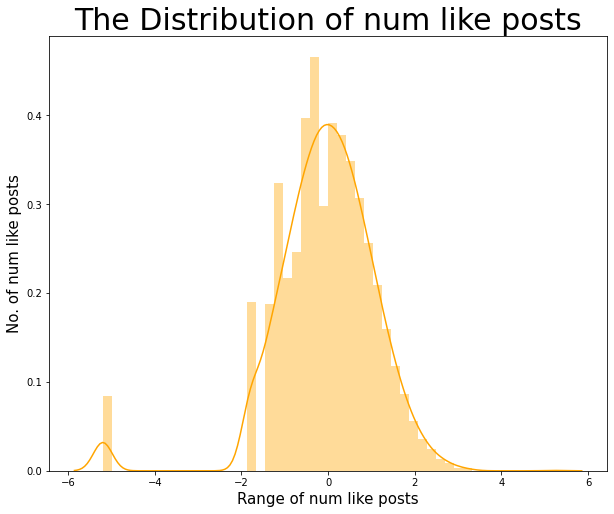

In [62]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.distplot(numerical_train['num_like_post'], color = 'orange')
plt.title('The Distribution of num like posts', fontsize = 30)
plt.xlabel('Range of num like posts', fontsize = 15)
plt.ylabel('No. of num like posts', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


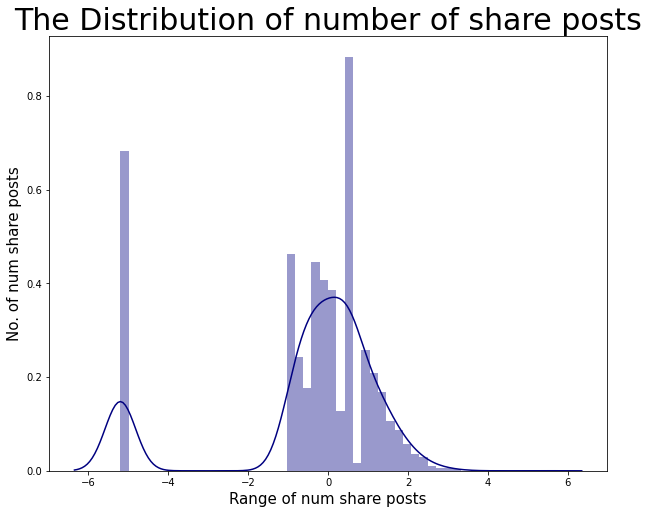

In [64]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.distplot(numerical_train['num_share_post'], color = 'navy')
plt.title('The Distribution of number of share posts', fontsize = 30)
plt.xlabel('Range of num share posts', fontsize = 15)
plt.ylabel('No. of num share posts', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


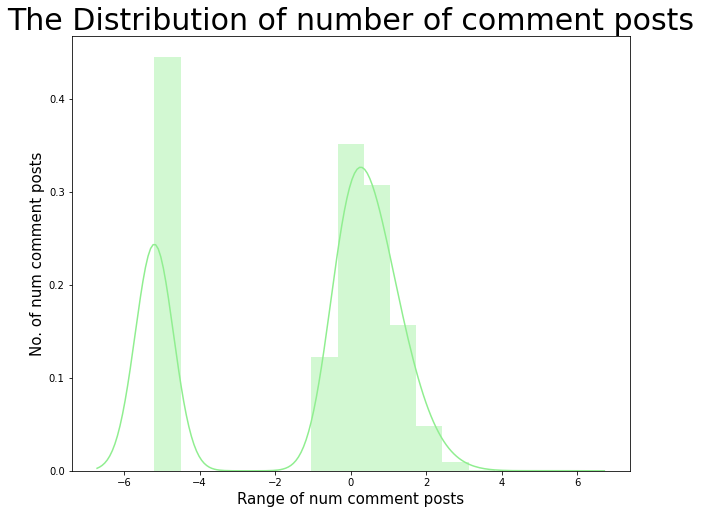

In [65]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.distplot(numerical_train['num_comment_post'], color = 'lightgreen')
plt.title('The Distribution of number of comment posts', fontsize = 30)
plt.xlabel('Range of num comment posts', fontsize = 15)
plt.ylabel('No. of num comment posts', fontsize = 15)
plt.show()

In [35]:
class BERTConcatFeatures(BertPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    self.bert = BertModel(config)
    combined_features_size = config.hidden_size * 4 + config.numerical_feat_size
    self.batch_norm = nn.BatchNorm1d(config.numerical_feat_size)
    self.classifier = torch.nn.Linear(combined_features_size, self.num_labels)
    
  def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None,
              head_mask=None, input_embeds=None, labels=None, class_weights=None,
              output_attentions=None, output_hidden_states=None,
              numerical_features=None):
    outputs = self.bert(input_ids, attention_mask=attention_mask, position_ids=position_ids, head_mask=head_mask)[2]
    #numerical_features = self.batch_norm(numerical_features)
    combined_features = torch.cat((outputs[-1][:, 0, ...], outputs[-2][:, 0, ...], outputs[-3][:, 0, ...], outputs[-4][:, 0, ...], numerical_features), -1)
    logits = self.classifier(combined_features)

    return logits

In [36]:
config_path = '/content/drive/MyDrive/VLSP-Fake-News-Detection/config/vbert_1.json'
single_model_config = json.load(open(config_path, 'r'))

In [37]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(torch.cuda.get_device_name())

Tesla P100-PCIE-16GB


In [38]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [39]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [49]:
seed = 9627
seed_everything(seed)
print("===Use BERT model===")
checkpoint_dir = '/content/drive/MyDrive/VLSP-Fake-News-Detection/trained_models/vbert_concat/'
tokenizer = BertTokenizer.from_pretrained("FPTAI/vibert-base-cased", do_lower_case=False)
tokenizer.add_tokens(['<url>'])
config = BertConfig.from_pretrained("FPTAI/vibert-base-cased", num_labels=1, output_hidden_states=True)

config.numerical_feat_size = len(numerical_train.columns)
model = BERTConcatFeatures.from_pretrained(single_model_config['model_name'], config=config)
model.to(device)
tsfm = model.bert

===Use BERT model===


Downloading:   0%|          | 0.00/581M [00:00<?, ?B/s]

Some weights of the model checkpoint at FPTAI/vibert-base-cased were not used when initializing BERTConcatFeatures: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BERTConcatFeatures from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BERTConcatFeatures from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BERTConcatFeatures were not initialized from the model checkpoint at FPTAI

In [41]:
def isnan(s):
  return s != s

In [42]:
def convert_tokens_to_ids(texts, tokenizer, max_seq_length=256, labels=None):
    input_ids, attention_masks = [], []
    for text in texts:
        inputs = tokenizer.encode_plus(text, padding='max_length', max_length=max_seq_length, truncation=True)
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    if labels is not None:
        return torch.tensor(input_ids, dtype=torch.int64), torch.tensor(attention_masks, dtype=torch.int64), torch.tensor(
            labels, dtype=torch.int64)
    return torch.tensor(input_ids, dtype=torch.int64), torch.tensor(attention_masks, dtype=torch.int64)

In [43]:
def save_checkpoint(model, tokenizer, checkpoint_path, epoch='best'):
    torch.save(model.state_dict(), os.path.join(
        checkpoint_path, f'model_{epoch}.bin'))
    model.config.to_json_file(os.path.join(checkpoint_path, 'config.json'))
    tokenizer.save_vocabulary(checkpoint_path)

In [44]:
def eval(val_loader, model, epoch, device):
    # Evaluate model
    model.eval()
    y_val = []
    val_preds = None
    print(f"EPOCH {epoch + 1}: ===EVALUATION===")
    for (input_ids, numerical_feat, attention_mask, y_batch) in val_loader:
        y_pred = model(input_ids.to(device), numerical_features=numerical_feat.to(device), attention_mask=attention_mask.to(device))
        y_pred = y_pred.squeeze().detach().cpu().numpy()
        val_preds = np.atleast_1d(y_pred) if val_preds is None else np.concatenate(
            [val_preds, np.atleast_1d(y_pred)])
        y_val.extend(y_batch.tolist())

    val_preds = sigmoid(val_preds)
    score = f1_score(y_val, val_preds > 0.5, pos_label=0)
    roc_score = roc_auc_score(y_val, val_preds)
    print(f"PREDICT {sum(val_preds <= 0.5)} INFORMATIVES")
    print(f"ACTUALY {len(y_val) - sum(y_val)} INFORMATIVES")

    print(
        f"\n----- F1 score @0.5 = {score:.4f}\nROC-AUC Score = {roc_score:.4f}")
    return roc_score

In [45]:
def predict(test_df, numerical_test, model, config, tweet_tokenizer, vncorenlp, model_tokenizer):
    test_normalized_texts = []
    test_post_ids = []
    for row in test_df.iterrows():
        if not isnan(row[1]['post_message']):
            test_normalized_texts.append(
                normalizePost(row[1]['post_message'], tweet_tokenizer, vncorenlp, use_segment=config['use_wordsegment'],
                              remove_punc_stopword=config['remove_punc_stopword'], lowercase_opt=False, truncation_method="head_only"))
            test_post_ids.append(row[1]['id'])

    test_ids, test_masks = convert_tokens_to_ids(test_normalized_texts, model_tokenizer)
    numerical_test = numerical_test.iloc[~numerical_test.index.isin(error_label_idx)]
    test_numerical_features = torch.tensor(numerical_test.values, dtype=torch.int64)

    test_dataset = TensorDataset(test_ids, test_numerical_features, test_masks)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    model.eval()
    test_preds = None
    for i, (input_ids, num_feat, masks) in enumerate(test_dataloader):
        if i % 20 == 0 or i == len(test_dataloader):
            print(f"Predicted {i} posts.")
        y_pred = model(input_ids.cuda(), numerical_features = num_feat.cuda(), attention_mask=masks.cuda())
        y_pred = y_pred.squeeze().detach().cpu().numpy()
        test_preds = np.atleast_1d(y_pred) if test_preds is None else np.concatenate(
            [test_preds, np.atleast_1d(y_pred)])

    test_preds = sigmoid(test_preds)
    test_preds = test_preds.tolist()
    final_result = []
    for post_id, test_pred in zip(test_post_ids, test_preds):
      final_result.append([post_id, test_pred])
    
    result_df = DataFrame(final_result)
    result_df.to_csv('/content/drive/MyDrive/VLSP-Fake-News-Detection/results.csv', index=False)

In [46]:
EPOCHS = 4
BATCH_SIZE = 32
ACCUMULATION_STEPS = 6
LEARNING_RATE = 1e-5

In [67]:
error_label_idx = []
tr_texts = []
for i, post in enumerate(data_train.post_message):
  if not isnan(post):
    tr_texts.append(normalizePost(post, tweet_tokenizer, rdrsegmenter, use_segment=True, remove_punc_stopword=False, lowercase_opt=False, truncation_method="head_only"))
  else:
    error_label_idx.append(i)
tr_labels = data_train.iloc[~data_train.index.isin(error_label_idx)].label.to_list()
numerical_train = numerical_train.iloc[~numerical_train.index.isin(error_label_idx)]
numerical_features = torch.tensor(numerical_train.values, dtype=torch.int64)

train_ids, train_masks, train_labels = convert_tokens_to_ids(tr_texts, tokenizer, 256, tr_labels)
dataset = TensorDataset(train_ids, numerical_features, train_masks, train_labels)
# train_sampler = torch.utils.data.RandomSampler(train_dataset)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

In [68]:
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 3917
Validation set size: 436


In [69]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

val_sampler = torch.utils.data.RandomSampler(val_dataset)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

In [70]:
num_train_optimization_steps = int(EPOCHS * len(train_dataset) / BATCH_SIZE / ACCUMULATION_STEPS)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(
        np in n for np in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(
        np in n for np in no_decay)], 'weight_decay': 0.01}
]

optimizer = AdamW(optimizer_grouped_parameters,lr=LEARNING_RATE, correct_bias=False)
scheduler0 = get_constant_schedule(optimizer)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_train_optimization_steps)

for child in tsfm.children():
  for param in child.parameters():
    param.require_grad = False

#Convert to iterator
frozen = True
best_score = 0.0
for epoch in range(EPOCHS):
  if epoch > 0 and frozen:
    for child in tsfm.children():
      for param in child.parameters():
        param.requires_grad = True

    frozen = False
    del scheduler0
    torch.cuda.empty_cache()
    gc.collect()
  optimizer.zero_grad()    
  print('\n------ Start training on Epoch: %d/%d' % (epoch + 1, EPOCHS))
  avg_loss = 0
  avg_accuracy = 0
  model.train()

  for i, (input_ids, numerical_feat, attention_mask, y_batch) in enumerate(train_loader):
    if(i % 20 == 0 and not i == 0) or (i == len(train_loader)):
      print(f"Training batch {i} of {len(train_loader)}")
    optimizer.zero_grad()
    y_pred = model(input_ids.to(device), numerical_features=numerical_feat.to(device), attention_mask=attention_mask.to(device))
    loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred.view(-1).to(device), y_batch.float().to(device))
    loss = loss.mean()
    loss.backward()
    optimizer.step()

    lossf = loss.item()
    avg_loss += loss.item() / len(train_loader)

  if not frozen:
    scheduler.step()
  else:
    scheduler0.step()
  optimizer.zero_grad()

  roc_score = eval(val_loader, model, epoch, "cuda")
  if roc_score >= best_score:
    best_score = roc_score
    save_checkpoint(model, tokenizer, checkpoint_dir, epoch=seed)
    print("Updated best score model!!! -------<{}>" % best_score)
  print("==================Done=============")


------ Start training on Epoch: 1/4
Training batch 20 of 123
Training batch 40 of 123
Training batch 60 of 123
Training batch 80 of 123
Training batch 100 of 123
Training batch 120 of 123
EPOCH 1: ===EVALUATION===
PREDICT 289 INFORMATIVES
ACTUALY 374 INFORMATIVES

----- F1 score @0.5 = 0.7421
ROC-AUC Score = 0.4801
Updated best score model!!! -------<{}>
==================Done=============

------ Start training on Epoch: 2/4
Training batch 20 of 123
Training batch 40 of 123
Training batch 60 of 123
Training batch 80 of 123
Training batch 100 of 123
Training batch 120 of 123
EPOCH 2: ===EVALUATION===
PREDICT 362 INFORMATIVES
ACTUALY 374 INFORMATIVES

----- F1 score @0.5 = 0.9375
ROC-AUC Score = 0.9166
Updated best score model!!! -------<{}>
==================Done=============

------ Start training on Epoch: 3/4
Training batch 20 of 123
Training batch 40 of 123
Training batch 60 of 123
Training batch 80 of 123
Training batch 100 of 123
Training batch 120 of 123
EPOCH 3: ===EVALUATION=

In [71]:
test_config_path = "/content/drive/MyDrive/VLSP-Fake-News-Detection/trained_models/vbert_concat/model_9627.bin"
test_config = BertConfig.from_pretrained("/content/drive/MyDrive/VLSP-Fake-News-Detection/trained_models/vbert_concat", num_labels=1, output_hidden_states=True)
test_model = BERTConcatFeatures.from_pretrained(test_config_path, config=test_config)
test_model.to(device)
test_tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/VLSP-Fake-News-Detection/trained_models/vbert_concat", do_lower_case=False)

In [72]:
predict(data_test, numerical_test, test_model, single_model_config, tweet_tokenizer, rdrsegmenter, test_tokenizer)

Predicted 0 posts.
Predicted 20 posts.
Predicted 40 posts.
Predicted 60 posts.
Predicted 80 posts.
Predicted 100 posts.
Predicted 120 posts.
Predicted 140 posts.
Predicted 160 posts.
Predicted 180 posts.
Predicted 200 posts.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
